# 6-1. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

https://github.com/e9t/nsmc

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해 주세요

```
$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data
```

라이브러리 버전을 확인해 봅니다

---

사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


2) 데이터로더 구성
---
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
import numpy as np
import tensorflow as tf
import os

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [5]:
# Mecab 토크나이저와 불용어 정의
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [6]:
def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 제거 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 훈련 데이터의 중복된 텍스트 제거
    train_data = train_data.dropna(how='any')  # 훈련 데이터의 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 테스트 데이터의 중복된 텍스트 제거
    test_data = test_data.dropna(how='any')  # 테스트 데이터의 결측치 제거
    
    # 훈련 데이터 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 텍스트를 형태소 단위로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)
    
    # 테스트 데이터 토큰화 및 불용어 제거
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 텍스트를 형태소 단위로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 빈도수 계산 및 어휘 사전 생성
    words = np.concatenate(X_train).tolist()  # 훈련 데이터의 모든 단어를 하나의 리스트로 결합
    counter = Counter(words)  # 단어의 빈도수를 계산
    counter = counter.most_common(num_words - 4)  # 상위 (num_words - 4)개의 단어 추출
    # vocab = ['', '', '', ''] + [key for key, _ in counter]  # 어휘 사전 생성 (앞의 4개는 특수 토큰)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # 어휘 사전 생성 (앞의 4개는 특수 토큰)
    word_to_index = {word: index for index, word in enumerate(vocab)}  # 단어를 인덱스로 매핑
    
    # 단어 리스트를 인덱스 리스트로 변환하는 함수 정의
    def wordlist_to_indexlist(wordlist):
        # '<PAD>', '<BOS>', '<UNK>', '<UNUSED>' 특수 토큰 정의
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    # 훈련 및 테스트 데이터를 인덱스 형태로 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [7]:
# 데이터 로더 호출
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### maxlen=41 로 설정 됨

###  padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽 ? : pre 사용
RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다.
그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다.
따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됩니다.

### 현 모델들에서 실험 결과 post 와 pre 가 큰 차이가 나지 않아 post 를 사용하였음

In [11]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [12]:
print(index_to_word[0])     # '<PAD>' 가 출력됩니다. 
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(index_to_word[2])     # '<BOS>' 가 출력됩니다. 
print(index_to_word[3])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['영화'])
print(index_to_word[5])

<PAD>
<BOS>
<UNK>
<UNUSED>
5
영화


In [13]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  0


## 4) 모델 구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [14]:
# 훈련 데이터셋 분리
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
print(f'Train data 크기: {len(X_train)}, Val data 크기: {len(X_val)}')

Train data 크기: 116945, Val data 크기: 29237


## 5) 모델 훈련 개시
---


### 1. LSTM
```
model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(tf.keras.layers.LSTM(8))
model_LSTM.add(tf.keras.layers.Dense(8, activation='relu'))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))
```

1. Embedding Layer
    - 입력 차원 (input_dim): vocab_size = 10000
        - 어휘 사전의 크기, 즉 모델이 처리할 수 있는 단어의 총 개수를 나타냅니다.
    - 출력 차원 (output_dim): word_vector_dim = 300
        - 각 단어를 300차원의 벡터로 표현합니다.
    - 입력 형태 (input_shape): (None,)
        - 입력되는 문장의 길이는 가변적입니다. 문장은 단어 인덱스의 시퀀스로 표현됩니다.
  
  
2. LSTM Layer
    - 유닛 수: 8
        - LSTM 레이어의 은닉 상태 벡터의 크기입니다. 이 수치는 LSTM이 정보를 압축하는 정도를 나타내며, 레이어의 표현력과 복잡성을 결정합니다.
        - 이 레이어는 순차적인 데이터를 처리하며, 앞서 학습한 단어 벡터들을 시계열 형태로 받아들이고 문맥을 이해할 수 있는 정보를 추출합니다.
  
  
3. Dense Layer (Hidden Layer)
    - 유닛 수: 8
    - 활성화 함수 (activation): 'relu'
        - 은닉층에 ReLU 활성화 함수를 사용하여 비선형성을 도입합니다. 이 레이어는 추출된 특성을 가공하여 최종 출력 이전에 더 높은 표현력을 갖게 합니다.
  
  
4. Dense Layer (Output Layer)
    - 유닛 수: 1
        - 출력이 하나인 이유는 감정이 긍정인지 부정인지 이진 분류 문제이기 때문입니다.
    - 활성화 함수 (activation): 'sigmoid'
        - sigmoid 활성화 함수를 사용하여 0과 1 사이의 값을 출력하도록 합니다. 이 값은 문장이 긍정일 확률을 나타냅니다.


In [17]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# LSTM model 설계
model_LSTM = tf.keras.Sequential()
model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_LSTM.add(tf.keras.layers.Dense(8, activation='relu'))
model_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 콜백 설정 - 가장 좋은 모델을 저장하도록 설정
LSTM_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('LSTM_best_model.keras', save_best_only=True)

model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 훈련
LSTM_history = model_LSTM.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[LSTM_checkpoint_cb],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 8ms/step - loss: 0.5576 - accuracy: 0.6884 - val_loss: 0.3813 - val_accuracy: 0.8411
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3462 - accuracy: 0.8556 - val_loss: 0.3509 - val_accuracy: 0.8442
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3090 - accuracy: 0.8708 - val_loss: 0.3440 - val_accuracy: 0.8504
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2890 - accuracy: 0.8772 - val_loss: 0.3533 - val_accuracy: 0.8506
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2714 - accuracy: 0.8840 - val_loss: 0.3536 - val_accuracy: 0.8514
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2526 - accuracy: 0.8910 - val_loss: 0.3689 - val_accuracy: 0.8473
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2347 - accuracy: 0.8982 - val_loss: 0.3867 - val_accuracy: 0.8522
Epoch 

In [19]:
# 저장된 가장 좋은 모델 로드
LSTM_best_model = tf.keras.models.load_model('LSTM_best_model.keras')

# 테스트셋을 통한 모델 평가
LSTM_results = LSTM_best_model.evaluate(X_test, y_test, verbose=2)

print(LSTM_results)

1537/1537 - 3s - loss: 0.3493 - accuracy: 0.8489
[0.34930112957954407, 0.8489329814910889]


### 2. Bidirectional LSTM
```
model_BiRNN = tf.keras.Sequential()
model_BiRNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_BiRNN.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))  # Bidirectional LSTM 레이어
model_BiRNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_BiRNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 긍정/부정을 나타내는 1dim 출력
```

1. Embedding Layer
    - 입력 차원 (input_dim): vocab_size = 10000
        - 어휘 사전의 크기, 즉 모델이 처리할 수 있는 단어의 총 개수를 나타냅니다.
    - 출력 차원 (output_dim): word_vector_dim = 300
        - 각 단어를 300차원의 벡터로 표현합니다.
    - 입력 형태 (input_shape): (None,)
        - 입력되는 문장의 길이는 가변적입니다. 문장은 단어 인덱스의 시퀀스로 표현됩니다.
  
  
2. Bidirectional LSTM Layer
    - 유닛 수: 8
        - LSTM 레이어의 은닉 상태 벡터의 크기입니다. 이는 LSTM이 정보를 압축하는 정도를 나타내며, 레이어의 표현력과 복잡성을 결정합니다.
        - 이 레이어는 문장의 앞뒤 맥락을 모두 고려할 수 있게 해줍니다. 문맥을 이해하는 데에 있어 더 풍부한 정보를 제공합니다.
  
  
3. Dense Layer (Hidden Layer)
    - 유닛 수: 8
    - 활성화 함수 (activation): 'relu'
        - 은닉층에 ReLU 활성화 함수를 사용하여 비선형성을 도입합니다. 이 레이어는 추출된 특성을 가공하여 최종 출력 이전에 더 높은 표현력을 갖게 합니다.
  
  
4. Dense Layer (Output Layer)
    - 유닛 수: 1
        - 출력이 하나인 이유는 감정이 긍정인지 부정인지 이진 분류 문제이기 때문입니다.
    - 활성화 함수 (activation): 'sigmoid'
        - sigmoid 활성화 함수를 사용하여 0과 1 사이의 값을 출력하도록 합니다. 이 값은 문장이 긍정일 확률을 나타냅니다.


In [20]:
# 모델 구성 및 저장 콜백 추가
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 설계 - Bidirectional LSTM 모델
model_BiRNN = tf.keras.Sequential()
model_BiRNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_BiRNN.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))  # Bidirectional LSTM 레이어
model_BiRNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_BiRNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 긍정/부정을 나타내는 1dim 출력

model_BiRNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                6976      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,007,121
Trainable params: 1,007,121
Non-trainable params: 0
_________________________________________________________________


In [21]:
# 콜백 설정 - 가장 좋은 모델을 저장하도록 설정
BiRNN_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('BiRNN_best_model.keras', save_best_only=True)

# 모델 컴파일
model_BiRNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

# 모델 훈련
BiRNN_history = model_BiRNN.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[BiRNN_checkpoint_cb],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 5s 11ms/step - loss: 0.4603 - accuracy: 0.7910 - val_loss: 0.3753 - val_accuracy: 0.8373
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3349 - accuracy: 0.8601 - val_loss: 0.3622 - val_accuracy: 0.8439
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3089 - accuracy: 0.8717 - val_loss: 0.3536 - val_accuracy: 0.8508
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2886 - accuracy: 0.8809 - val_loss: 0.3543 - val_accuracy: 0.8496
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2680 - accuracy: 0.8897 - val_loss: 0.3544 - val_accuracy: 0.8508
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2476 - accuracy: 0.8983 - val_loss: 0.3587 - val_accuracy: 0.8541
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2276 - accuracy: 0.9060 - val_loss: 0.3734 - val_accuracy: 0.8516
Epoch

In [22]:
# 저장된 가장 좋은 모델 로드
BiRNN_best_model = tf.keras.models.load_model('BiRNN_best_model.keras')

# Bidirectional LSTM 모델 평가
BiRNN_results = BiRNN_best_model.evaluate(X_test, y_test, verbose=2)

print(BiRNN_results)

1537/1537 - 4s - loss: 0.3587 - accuracy: 0.8479
[0.3586982488632202, 0.8478548526763916]


### 3. Conv1D
```
model_Conv1D = tf.keras.Sequential()
model_Conv1D.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_Conv1D.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1D.add(tf.keras.layers.MaxPooling1D(5))
model_Conv1D.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1D.add(tf.keras.layers.GlobalMaxPooling1D())
model_Conv1D.add(tf.keras.layers.Dense(8, activation='relu'))
model_Conv1D.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
```

1. Embedding Layer
    - 입력 차원 (input_dim): vocab_size = 10000
        - 어휘 사전의 크기, 즉 모델이 처리할 수 있는 단어의 총 개수를 나타냅니다.
    - 출력 차원 (output_dim): word_vector_dim = 300
        - 각 단어를 300차원의 벡터로 표현합니다.
    - 입력 형태 (input_shape): (None,)
        - 입력되는 문장의 길이는 가변적입니다. 문장은 단어 인덱스의 시퀀스로 표현됩니다.
  
  
2. Conv1D Layer (첫 번째)
    - 필터 수: 16
        - 16개의 필터를 사용하여 입력 텍스트에서 특징을 추출합니다.
    - 커널 크기 (kernel_size): 7
        - 컨볼루션 필터의 크기입니다. 커널은 한 번에 7개의 단어를 보고 특징을 추출합니다.
    - 활성화 함수 (activation): 'relu'
        - ReLU 활성화 함수를 사용하여 비선형성을 도입하고, 중요한 특징을 강조합니다.
  
  
3. MaxPooling1D Layer
    - 풀링 크기 (pool_size): 5
        - MaxPooling1D는 입력 텐서에서 가장 큰 값을 선택해 다운샘플링을 합니다. 이 경우, 5개의 단어에 대해 가장 큰 값을 선택하여 입력을 압축합니다.
    - 이 레이어는 특징 맵을 축소하여 중요한 특징만 남기고, 과적합을 방지하는 데 도움이 됩니다.
  
  
4. Conv1D Layer (두 번째)
    - 필터 수: 16
        - 첫 번째 Conv1D 레이어와 동일하게 16개의 필터를 사용합니다.
    - 커널 크기 (kernel_size): 7
        - 첫 번째 Conv1D 레이어와 동일하게 7개의 단어를 한 번에 봅니다.
    - 활성화 함수 (activation): 'relu'
        - ReLU 활성화 함수를 사용합니다.
  
  
5. GlobalMaxPooling1D Layer
    - 전체 시퀀스에서 가장 큰 값을 선택하여 텐서를 1차원으로 변환합니다.
    - GlobalMaxPooling은 시퀀스 전체에서 최댓값을 선택하여 중요한 특징을 추출합니다. 이는 데이터의 길이에 관계없이 고정된 크기의 출력 벡터를 생성합니다.
    - 이 레이어는 시퀀스의 길이를 무시하고 시퀀스 전체에서 가장 중요한 정보를 유지합니다.
  
  
6. Dense Layer (Hidden Layer)
    - 유닛 수: 8
    - 활성화 함수 (activation): 'relu'
        - 은닉층에 ReLU 활성화 함수를 사용하여 비선형성을 도입합니다. 이 레이어는 추출된 특성을 가공하여 최종 출력 이전에 더 높은 표현력을 갖게 합니다.
  
  
7. Dense Layer (Output Layer)
    - 유닛 수: 1
        - 출력이 하나인 이유는 감정이 긍정인지 부정인지 이진 분류 문제이기 때문입니다.
    - 활성화 함수 (activation): 'sigmoid'
        - sigmoid 활성화 함수를 사용하여 0과 1 사이의 값을 출력하도록 합니다. 이 값은 문장이 긍정일 확률을 나타냅니다.


In [23]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 구성 - Conv1D 모델
model_Conv1D = tf.keras.Sequential()
model_Conv1D.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_Conv1D.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1D.add(tf.keras.layers.MaxPooling1D(5))
model_Conv1D.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1D.add(tf.keras.layers.GlobalMaxPooling1D())
model_Conv1D.add(tf.keras.layers.Dense(8, activation='relu'))
model_Conv1D.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_Conv1D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [24]:
# 콜백 설정 - 가장 좋은 모델을 저장하도록 설정
Conv1D_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('Conv1D_best_model.keras', save_best_only=True)

# 모델 컴파일
model_Conv1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

# 모델 훈련
Conv1D_history = model_BiRNN.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[Conv1D_checkpoint_cb],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0800 - accuracy: 0.9717 - val_loss: 0.7450 - val_accuracy: 0.8357
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0774 - accuracy: 0.9730 - val_loss: 0.7829 - val_accuracy: 0.8372
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0744 - accuracy: 0.9739 - val_loss: 0.7742 - val_accuracy: 0.8328
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0711 - accuracy: 0.9755 - val_loss: 0.8041 - val_accuracy: 0.8337
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0651 - accuracy: 0.9777 - val_loss: 0.8565 - val_accuracy: 0.8351
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0613 - accuracy: 0.9792 - val_loss: 0.8654 - val_accuracy: 0.8330
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0575 - accuracy: 0.9804 - val_loss: 0.9152 - val_accuracy: 0.8324
Epoch 

In [25]:
# 저장된 가장 좋은 모델 로드
Conv1D_best_model = tf.keras.models.load_model('Conv1D_best_model.keras')

# Bidirectional LSTM 모델 평가
Conv1D_results = Conv1D_best_model.evaluate(X_test, y_test, verbose=2)

print(Conv1D_results)

1537/1537 - 4s - loss: 0.7323 - accuracy: 0.8367
[0.7323043942451477, 0.8366661667823792]


## 6) Loss, Accuracy 그래프 시각화
---

In [26]:
# 학습 및 검증 손실, 정확도 시각화 함수 추가
import matplotlib.pyplot as plt

In [27]:
def plot_training_history(history):
    # Training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.show()

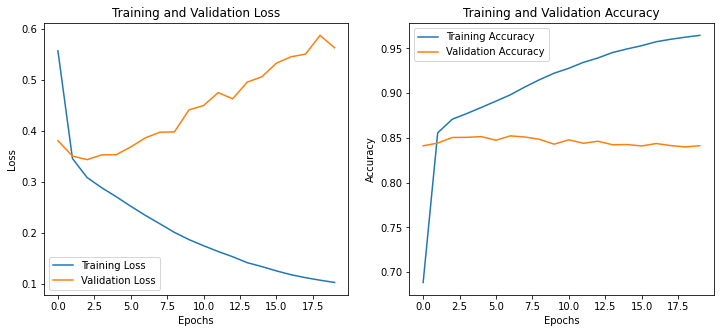

In [28]:
# LSTM 모델 시각화
# Epochs 4 정도 부터 오버피팅 나타남
plot_training_history(LSTM_history)

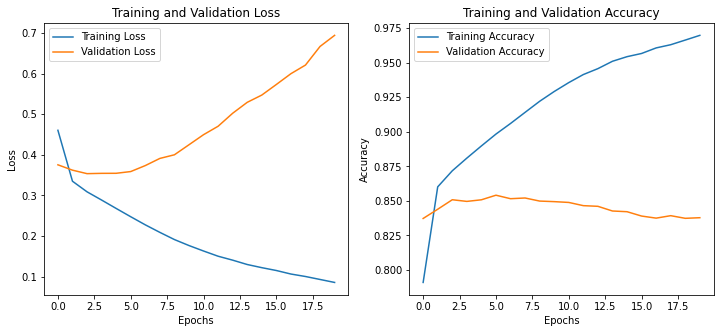

In [29]:
# Bidirectional LSTM 모델 시각화
# Epochs 5 정도 부터 오버피팅 나타남
plot_training_history(BiRNN_history)

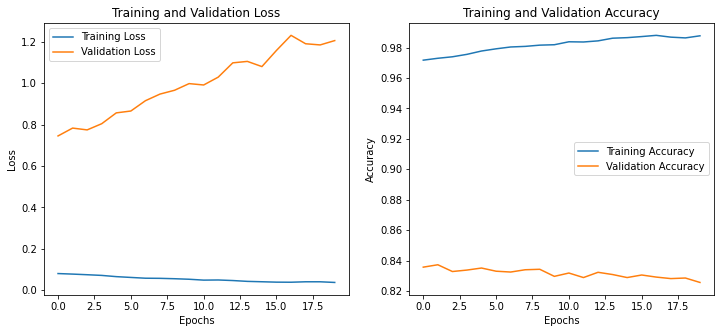

In [30]:
# Conv1D 모델 시각화
# 오버피팅 바로 나옴
plot_training_history(Conv1D_history)

## 7) 학습된 Embedding 레이어 분석
---

### LSTM 의 Embedding 레이어

In [31]:
embedding_layer = model_LSTM.layers[0]  # 모델의 첫 번째 레이어가 임베딩 레이어라고 가정.
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [32]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-2.12747641e-02, -4.72076200e-02,  1.37153398e-02, -2.50737462e-02,
        4.61124443e-02,  2.38782130e-02, -6.25438839e-02,  5.04824966e-02,
        1.66724548e-02, -4.66947593e-02, -4.05097231e-02, -4.87872623e-02,
       -5.84988445e-02,  8.27544741e-03, -5.56667820e-02,  7.24447146e-02,
       -2.38104071e-02,  3.90001535e-02, -1.48051558e-02,  2.03141682e-02,
        3.72966565e-02, -5.94874993e-02,  1.75771571e-03, -2.97330711e-02,
       -4.57608774e-02, -3.42916958e-02, -1.73184108e-02,  3.47019406e-03,
       -6.82513649e-03, -5.33290505e-02, -3.23056057e-02,  6.40969276e-02,
        1.57972034e-02,  3.26381288e-02,  2.01249141e-02,  3.05932816e-02,
        5.28240576e-02, -1.01774044e-01, -2.37398278e-02, -1.76710600e-03,
        2.64536083e-01, -4.69232502e-04, -1.63450111e-02, -2.91144010e-02,
       -3.16581391e-02, -7.83556327e-03,  3.86772081e-02,  4.22765361e-03,
       -1.04835235e-01, -7.53556639e-02,  1.15087032e-02, -7.16471076e-02,
        6.27751835e-03, -

In [34]:
word_vectors.similar_by_word("사랑")

[('멋지', 0.8617097735404968),
 ('여하튼', 0.8391941785812378),
 ('누군가', 0.8388642072677612),
 ('명작', 0.8307030200958252),
 ('정조', 0.8285664319992065),
 ('수작', 0.825328528881073),
 ('예언', 0.8236479163169861),
 ('돌아보', 0.8186804056167603),
 ('현실', 0.8182114958763123),
 ('완벽', 0.8182094097137451)]

### 사랑이라는 단어와 유사한 단어라고 보기 어렵다!

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
---
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.  
참고 링크1 : https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models  
참고 링크2 : https://radimrehurek.com/gensim/models/keyedvectors.html

```python
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]
```

심볼릭 링크 연결

```bash
ln -s ~/data/*.* ~/aiffel/sentiment_classification/data
```

In [35]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from keras.preprocessing.sequence import pad_sequences

In [36]:
# 한국어 Word2Vec 모델 로드
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["끝"]

In [37]:
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [66]:
word_vectors.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

In [38]:
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

### 한국어 Word2Vec 모델을 사용하면 영화, 사랑이라는 단어와 유사한 단어가 잘 나타난다!!!

In [39]:
# # Word2Vec 임베딩 매트릭스 생성
# embedding_matrix = np.zeros((len(word_to_index), word_vectors.wv.vector_size))
# for word, i in word_to_index.items():
#     if word in word_vectors.wv:
#         embedding_matrix[i] = word_vectors.wv[word]

embedding_matrix = np.zeros((len(word_to_index), word_vectors.wv.vector_size))
# embedding_matrix = np.random.rand((len(word_to_index), word_vectors.wv.vector_size))

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,len(word_to_index)):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [40]:
print(f'word_to_index의 크기: {len(word_to_index)}')
print(f'word_vectors.vector_size: {word_vectors.wv.vector_size}')

word_to_index의 크기: 10000
word_vectors.vector_size: 100


In [43]:
from tensorflow.keras.initializers import Constant

In [44]:
# LSTM 모델 구성
vocab_size = len(word_to_index)
word_vector_dim = word_vectors.vector_size  # Word2Vec 임베딩 차원 수

model_LSTM_Word2Vec = tf.keras.Sequential()
model_LSTM_Word2Vec.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTM_Word2Vec.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_LSTM_Word2Vec.add(tf.keras.layers.Dense(8, activation='relu'))
model_LSTM_Word2Vec.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM_Word2Vec.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [45]:
# 콜백 설정 - 가장 좋은 모델을 저장하도록 설정
LSTM_Word2Vec_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('LSTM_Word2Vec_best_model.keras', save_best_only=True)

model_LSTM_Word2Vec.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 훈련
LSTM_Word2Vec_history = model_LSTM_Word2Vec.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[LSTM_Word2Vec_checkpoint_cb],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 8ms/step - loss: 0.6145 - accuracy: 0.6606 - val_loss: 0.5012 - val_accuracy: 0.7717
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4467 - accuracy: 0.8011 - val_loss: 0.4142 - val_accuracy: 0.8220
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3827 - accuracy: 0.8353 - val_loss: 0.3850 - val_accuracy: 0.8331
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3503 - accuracy: 0.8504 - val_loss: 0.3727 - val_accuracy: 0.8406
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3285 - accuracy: 0.8627 - val_loss: 0.3747 - val_accuracy: 0.8413
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3128 - accuracy: 0.8706 - val_loss: 0.3654 - val_accuracy: 0.8452
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3011 - accuracy: 0.8770 - val_loss: 0.3613 - val_accuracy: 0.8454
Epoch 

In [46]:
# 저장된 가장 좋은 모델 로드
LSTM_Word2Vec_best_model = tf.keras.models.load_model('LSTM_Word2Vec_best_model.keras')

# 테스트셋을 통한 모델 평가
LSTM_Word2Vec_results = LSTM_Word2Vec_best_model.evaluate(X_test, y_test, verbose=2)

print(LSTM_Word2Vec_results)

1537/1537 - 3s - loss: 0.3652 - accuracy: 0.8446
[0.36521098017692566, 0.8445999622344971]


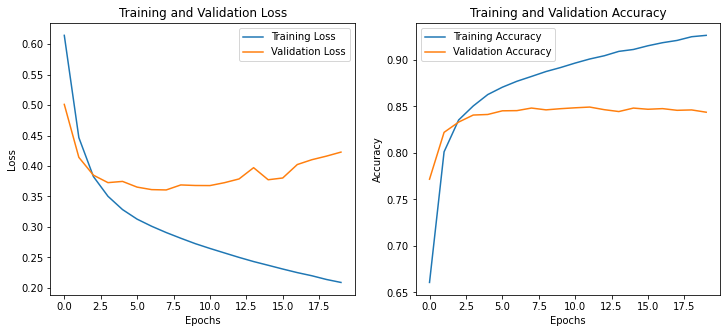

In [47]:
# LSTM_Word2Vec 모델 시각화
plot_training_history(LSTM_Word2Vec_history)

In [48]:
# 모델 설계 - Bidirectional LSTM 모델
vocab_size = len(word_to_index)
word_vector_dim = word_vectors.vector_size  # Word2Vec 임베딩 차원 수

model_BiRNN_Word2Vec = tf.keras.Sequential()
model_BiRNN_Word2Vec.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_BiRNN_Word2Vec.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)))  # Bidirectional LSTM 레이어
model_BiRNN_Word2Vec.add(tf.keras.layers.Dense(8, activation='relu'))
model_BiRNN_Word2Vec.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 긍정/부정을 나타내는 1dim 출력

model_BiRNN_Word2Vec.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                6976      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,007,121
Trainable params: 1,007,121
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 콜백 설정 - 가장 좋은 모델을 저장하도록 설정
BiRNN_Word2Vec_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('BiRNN_Word2Vec_best_model.keras', save_best_only=True)

# 모델 컴파일
model_BiRNN_Word2Vec.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

# 모델 훈련
BiRNN_Word2Vec_history = model_BiRNN.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[BiRNN_Word2Vec_checkpoint_cb],
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0345 - accuracy: 0.9889 - val_loss: 1.2407 - val_accuracy: 0.8294
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0326 - accuracy: 0.9897 - val_loss: 1.3032 - val_accuracy: 0.8274
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 1.2673 - val_accuracy: 0.8297
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0334 - accuracy: 0.9890 - val_loss: 1.3670 - val_accuracy: 0.8302
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0314 - accuracy: 0.9896 - val_loss: 1.3265 - val_accuracy: 0.8289
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0295 - accuracy: 0.9903 - val_loss: 1.3570 - val_accuracy: 0.8306
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 1.4153 - val_accuracy: 0.8270
Epoch 

In [50]:
# 저장된 가장 좋은 모델 로드
BiRNN_Word2Vec_best_model = tf.keras.models.load_model('BiRNN_Word2Vec_best_model.keras')

# Bidirectional LSTM 모델 평가
BiRNN_Word2Vec_results = BiRNN_Word2Vec_best_model.evaluate(X_test, y_test, verbose=2)

print(BiRNN_Word2Vec_results)

1537/1537 - 4s - loss: 1.2405 - accuracy: 0.8292
[1.240468144416809, 0.8291596174240112]


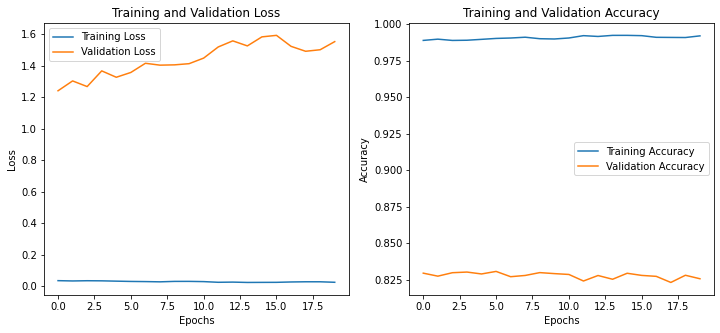

In [51]:
# Bidirectional LSTM 모델 시각화
plot_training_history(BiRNN_Word2Vec_history)

In [84]:
# CConv1D 모델 구성
# Dropout 추가
vocab_size = len(word_to_index)
word_vector_dim = word_vectors.vector_size  # Word2Vec 임베딩 차원 수

model_Conv1D_Word2Vec = tf.keras.Sequential()
model_Conv1D_Word2Vec.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_Conv1D_Word2Vec.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1D_Word2Vec.add(tf.keras.layers.Dropout(0.5))
model_Conv1D_Word2Vec.add(tf.keras.layers.Dropout(0.5))
model_Conv1D_Word2Vec.add(tf.keras.layers.MaxPooling1D(5))
model_Conv1D_Word2Vec.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_Conv1D_Word2Vec.add(tf.keras.layers.GlobalMaxPooling1D())
model_Conv1D_Word2Vec.add(tf.keras.layers.Dense(8, activation='relu'))
model_Conv1D_Word2Vec.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_Conv1D_Word2Vec.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 35, 16)            11216     
_________________________________________________________________
dropout_10 (Dropout)         (None, 35, 16)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 35, 16)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)              

In [85]:
# # Conv1D 모델 구성
# # BatchNormalization 추가
# vocab_size = len(word_to_index)
# word_vector_dim = word_vectors.vector_size  # Word2Vec 임베딩 차원 수

# model_Conv1D_Word2Vec = tf.keras.Sequential()
# model_Conv1D_Word2Vec.add(tf.keras.layers.Embedding(vocab_size, 
#                                  word_vector_dim, 
#                                  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
#                                  input_length=maxlen, 
#                                  trainable=True))   # trainable을 True로 주면 Fine-tuning
# model_Conv1D_Word2Vec.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model_Conv1D_Word2Vec.add(tf.keras.layers.BatchNormalization())
# model_Conv1D_Word2Vec.add(tf.keras.layers.BatchNormalization())
# model_Conv1D_Word2Vec.add(tf.keras.layers.Dropout(0.5))
# model_Conv1D_Word2Vec.add(tf.keras.layers.Dropout(0.5))
# model_Conv1D_Word2Vec.add(tf.keras.layers.MaxPooling1D(5))
# model_Conv1D_Word2Vec.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model_Conv1D_Word2Vec.add(tf.keras.layers.GlobalMaxPooling1D())
# model_Conv1D_Word2Vec.add(tf.keras.layers.Dense(8, activation='relu'))
# model_Conv1D_Word2Vec.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model_Conv1D_Word2Vec.summary()

In [86]:
# 콜백 설정 - 가장 좋은 모델을 저장하도록 설정
Conv1D_Word2Vec_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('Conv1D_Word2Vec_best_model.keras', save_best_only=True)

# 모델 컴파일
model_Conv1D_Word2Vec.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 30  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

# 모델 훈련
Conv1D_Word2Vec_history = model_Conv1D_Word2Vec.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[Conv1D_Word2Vec_checkpoint_cb],
                    verbose=1)

Epoch 1/30
229/229 [==============================] - 2s 6ms/step - loss: 0.7278 - accuracy: 0.5308 - val_loss: 0.6817 - val_accuracy: 0.5978
Epoch 2/30
229/229 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6213 - val_loss: 0.6051 - val_accuracy: 0.7278
Epoch 3/30
229/229 [==============================] - 1s 5ms/step - loss: 0.5580 - accuracy: 0.7138 - val_loss: 0.5446 - val_accuracy: 0.7782
Epoch 4/30
229/229 [==============================] - 1s 5ms/step - loss: 0.4968 - accuracy: 0.7594 - val_loss: 0.4980 - val_accuracy: 0.8053
Epoch 5/30
229/229 [==============================] - 1s 5ms/step - loss: 0.4529 - accuracy: 0.7884 - val_loss: 0.4723 - val_accuracy: 0.8219
Epoch 6/30
229/229 [==============================] - 1s 5ms/step - loss: 0.4247 - accuracy: 0.8045 - val_loss: 0.4600 - val_accuracy: 0.8269
Epoch 7/30
229/229 [==============================] - 1s 5ms/step - loss: 0.4044 - accuracy: 0.8153 - val_loss: 0.4439 - val_accuracy: 0.8360
Epoch 

In [87]:
# 저장된 가장 좋은 모델 로드
Conv1D_Word2Vec_best_model = tf.keras.models.load_model('Conv1D_Word2Vec_best_model.keras')

# CConv1D 모델 평가
Conv1D_Word2Vec_results = Conv1D_Word2Vec_best_model.evaluate(X_test, y_test, verbose=2)

print(Conv1D_Word2Vec_results)

1537/1537 - 3s - loss: 0.3783 - accuracy: 0.8505
[0.3783297836780548, 0.8504790663719177]


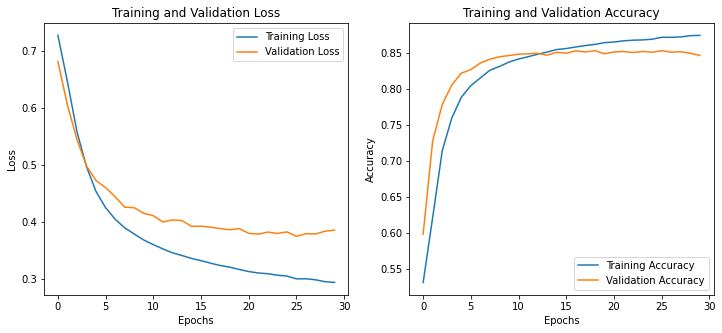

In [88]:
# Conv1D_Word2Vec 모델 시각화
plot_training_history(Conv1D_Word2Vec_history)

#### Dropout 을 추가해서 오버피팅 나오는 현상을 개선하였다!
#### Conv1D 모델에서 accuracy: 0.8505 가 잘 나왔다!

### 회고

1. 한국어 Word2Vec 에서 제공하는 워드 임베딩 벡터들끼리 의미적 유사도가 가까운 것을 확인 할 수 있었다.
```
word_vectors.wv.similar_by_word("사랑")
```
```
[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]
```
2. 모델과 하이퍼파라미터 조정을 통해 LSTM 보다 Conv1D 가 더 잘 나오는 현상도 확인 하였다.
3. Dropout 이 오버피팅 방지효과를 다시 한번 확인 할 수 있었다.
4. Transfomer 모델을 적용 해보고 싶었는데 시간이 부족했다.
5. 추후 적용 해 볼 예정이다.
